<a href="https://colab.research.google.com/github/ShinyQ/Time-Series_AEP-Energy-Consumption/blob/main/Time_Series_AEP_Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series - AEP Energy Consumption**

Nama : Kurniadi Ahmad Wijaya

Email: kurniadiahmadwijaya@gmail.com

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")

In [2]:
!gdown --id 1G41QoGNn7SB_ky16v4qcncjSO5tSEEXh

Downloading...
From: https://drive.google.com/uc?id=1G41QoGNn7SB_ky16v4qcncjSO5tSEEXh
To: /content/AEP_hourly.csv
3.40MB [00:00, 40.8MB/s]


In [3]:
df = pd.read_csv('AEP_hourly.csv')
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


### **Visualisasi Grafik**

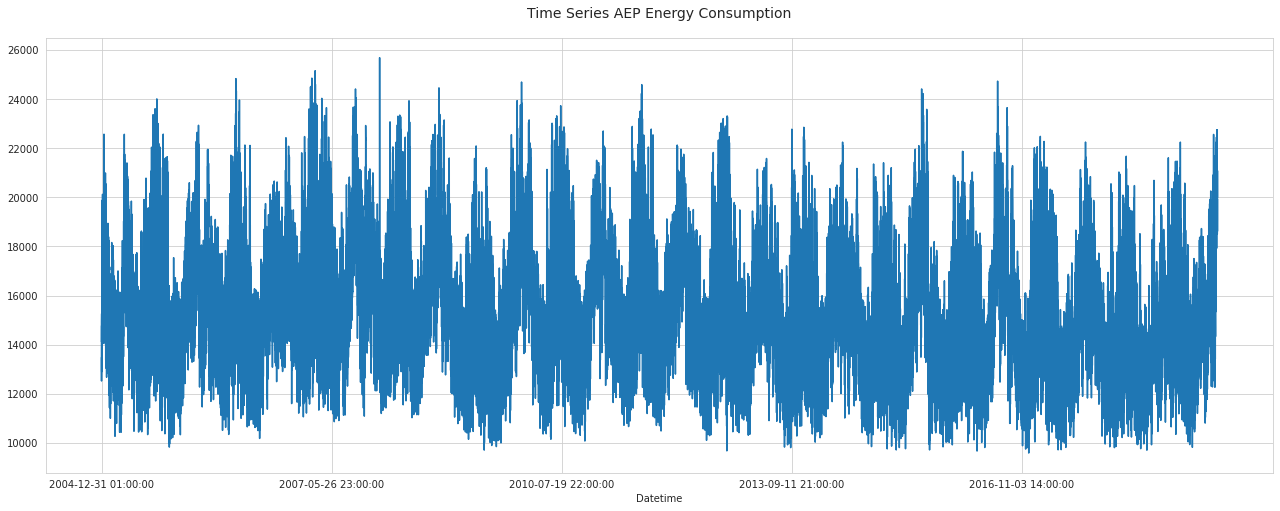

In [4]:
series = df.Datetime.astype(str)
value = df.AEP_MW.astype(np.float64).values

plt.figure(figsize=(22, 8))
plt.title('Time Series AEP Energy Consumption', fontsize="14", pad=20)
sns.lineplot(x=series, y=value, palette="deep", ci=None)
plt.xticks(series[0:len(df):25000])
sns.set_context("notebook", rc={"lines.linewidth": 2})
plt.show()

## **Preprocessing Data Latih**

### **Feature Scaling**

In [5]:
value = np.array(value).reshape(-1, 1)
series = list(series)

scaler = MinMaxScaler(feature_range=(0, 1))
value = scaler.fit_transform(value)

value = np.concatenate(value).ravel().tolist()
value[:5], series[:5]

([0.24183939431550205,
  0.20379793967978155,
  0.18592528236316241,
  0.18220181208886677,
  0.19169666128832064],
 ['2004-12-31 01:00:00',
  '2004-12-31 02:00:00',
  '2004-12-31 03:00:00',
  '2004-12-31 04:00:00',
  '2004-12-31 05:00:00'])

### **Train Test Split**

In [6]:
x_train, x_test, y_train, y_test = train_test_split(value, series, test_size = 0.2, shuffle = False)

print('Total Data Train : ', len(x_train))
print('Total Data Validation : ', len(x_test))

Total Data Train :  97018
Total Data Validation :  24255


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(x_train, window_size=64, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=64, batch_size=100, shuffle_buffer=1000)    

In [8]:
model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(1, activation="relu"),
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=SGD(learning_rate=1.0000e-04, momentum=0.9),
    metrics=["mae"]
)

### **Count Minimal MAE And Set Callback**

In [9]:
mae = (max(value) - min(value)) * 5/100
print('MAE :', mae)

MAE : 0.04999999999999999


In [10]:
class early_mae_stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < mae and logs.get('val_mae') < mae):
      print("\nMAE < 10% skala data")
      self.model.stop_training = True

early_mae_stop = early_mae_stop()

In [11]:
history = model.fit(
    train_set,
    epochs=100,
    callbacks=early_mae_stop,
    validation_data=val_set
)

Epoch 1/100
970/970 [==============================] - 247s 248ms/step - loss: 0.0280 - mae: 0.1843 - val_loss: 0.0104 - val_mae: 0.1161
Epoch 2/100
970/970 [==============================] - 233s 240ms/step - loss: 0.0105 - mae: 0.1160 - val_loss: 0.0102 - val_mae: 0.1152
Epoch 3/100
970/970 [==============================] - 235s 242ms/step - loss: 0.0102 - mae: 0.1144 - val_loss: 0.0099 - val_mae: 0.1137
Epoch 4/100
970/970 [==============================] - 233s 240ms/step - loss: 0.0100 - mae: 0.1131 - val_loss: 0.0097 - val_mae: 0.1122
Epoch 5/100
970/970 [==============================] - 232s 239ms/step - loss: 0.0098 - mae: 0.1118 - val_loss: 0.0095 - val_mae: 0.1107
Epoch 6/100
970/970 [==============================] - 233s 240ms/step - loss: 0.0096 - mae: 0.1106 - val_loss: 0.0093 - val_mae: 0.1093
Epoch 7/100
970/970 [==============================] - 232s 239ms/step - loss: 0.0094 - mae: 0.1093 - val_loss: 0.0091 - val_mae: 0.1078
Epoch 8/100
970/970 [====================

### **Testing Model**

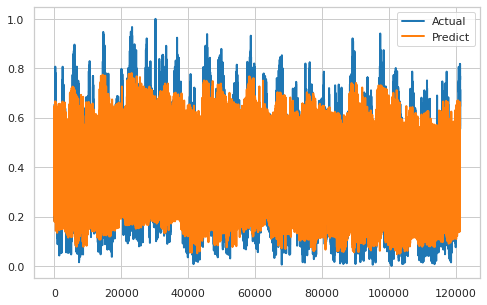

In [20]:
actual = value
x_train_set = windowed_dataset(actual, window_size=64, batch_size=100, shuffle_buffer=1000)  
predict = model.predict(x_train_set)

plt.figure(figsize=(8, 5))
plt.plot(actual, label='Actual')
plt.plot(predict, label='Predict')
plt.legend()
plt.show()

### **Result**

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 120)         29760     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense (Dense)                (None, 30)                3630      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 120,301
Trainable params: 120,301
Non-trainable params: 0
_________________________________________________________________


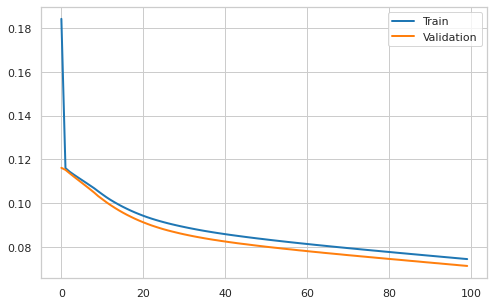

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(8, 5))
plt.plot(epochs, mae, label='Train')
plt.plot(epochs, val_mae, label='Validation')
plt.legend()
plt.show()